In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import (
    BertTokenizer,
    RobertaTokenizer,
    RobertaForSequenceClassification,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    AutoTokenizer,
    AutoModelForSequenceClassification
)
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_fscore_support,
    classification_report
)
import matplotlib.pyplot as plt
import wandb
import os
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
data = pd.read_csv("/kaggle/input/final-dataset/balanced_data.csv")

In [ ]:
data.isna().sum()

label          0
text           0
text_length    0
sentiment      0
dtype: int64

In [ ]:
data['label'].value_counts()

label
4    4331
3    2196
2    1427
5    1115
1     869
0     685
Name: count, dtype: int64

In [ ]:
data.dropna(inplace=True)

In [ ]:
data['label'] = data['label'].astype(int)

In [ ]:
data['label'].value_counts()

label
4    4331
3    2196
2    1427
5    1115
1     869
0     685
Name: count, dtype: int64

In [ ]:
train_df, temp_df = train_test_split(data, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [ ]:
train_data = Dataset.from_pandas(train_df)
val_data = Dataset.from_pandas(val_df)
test_data = Dataset.from_pandas(test_df)

## PhoBERT

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=258)

# Apply the tokenizer to all splits
train_dataset = train_data.map(tokenize_function, batched=True)
val_dataset = val_data.map(tokenize_function, batched=True)
test_dataset = test_data.map(tokenize_function, batched=True)

Map:   0%|          | 0/8498 [00:00<?, ? examples/s]

Map:   0%|          | 0/1062 [00:00<?, ? examples/s]

Map:   0%|          | 0/1063 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=6)

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(p):
    preds, labels = p
    preds = preds.argmax(axis=1)  # Get the index of max probability for each prediction
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,                # Bạn có thể thử 10 epoch
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir='./logs',
    logging_steps=10,
    weight_decay=0.01,
    warmup_steps=500,
    max_grad_norm=1.0,
    # Giới hạn sớm khi không cải thiện
    eval_steps=500,
    save_total_limit=2,
)

In [ ]:
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=4)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]  # Thêm callback early stopping
)

In [ ]:
wandb.login(key="e37c22cc6db271d99d8b58dafc9abe1ce81fae1b")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Start training
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: 0934711234luong (0934711234luong-uit). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.7
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241215_025756-8sxtv9f9
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./results
wandb: ⭐️ View project at https://wandb.ai/0934711234luong-uit/huggingface
wandb: 🚀 View run at https://wandb.ai/0934711234luong-uit/huggingface/runs/8sxtv9f9


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.167400,1.077491,0.596987,0.674401,0.596987,0.591085
2,1.123400,0.988190,0.641243,0.624201,0.641243,0.619736
3,0.945900,0.959195,0.684557,0.668279,0.684557,0.665532
4,0.603000,1.135264,0.648776,0.628045,0.648776,0.632970
5,0.770700,1.284521,0.629002,0.638508,0.629002,0.632412
6,0.441500,1.362693,0.622411,0.641187,0.622411,0.629091
7,0.462500,1.560620,0.601695,0.630388,0.601695,0.609955


TrainOutput(global_step=3724, training_loss=0.6901723769534416, metrics={'train_runtime': 2098.6844, 'train_samples_per_second': 80.984, 'train_steps_per_second': 5.07, 'total_flos': 7887133746899568.0, 'train_loss': 0.6901723769534416, 'epoch': 7.0})

In [ ]:
results = trainer.evaluate(test_dataset)
print(f"Evaluation Results: {results}")

Evaluation Results: {'eval_loss': 1.035352349281311, 'eval_accuracy': 0.6415804327375353, 'eval_precision': 0.6547669893618091, 'eval_recall': 0.6415804327375353, 'eval_f1': 0.6160063428034996, 'eval_runtime': 9.6677, 'eval_samples_per_second': 109.953, 'eval_steps_per_second': 3.517, 'epoch': 7.0}


In [ ]:
history = trainer.state.log_history
train_loss = [entry['loss'] for entry in history if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in history if 'eval_loss' in entry]

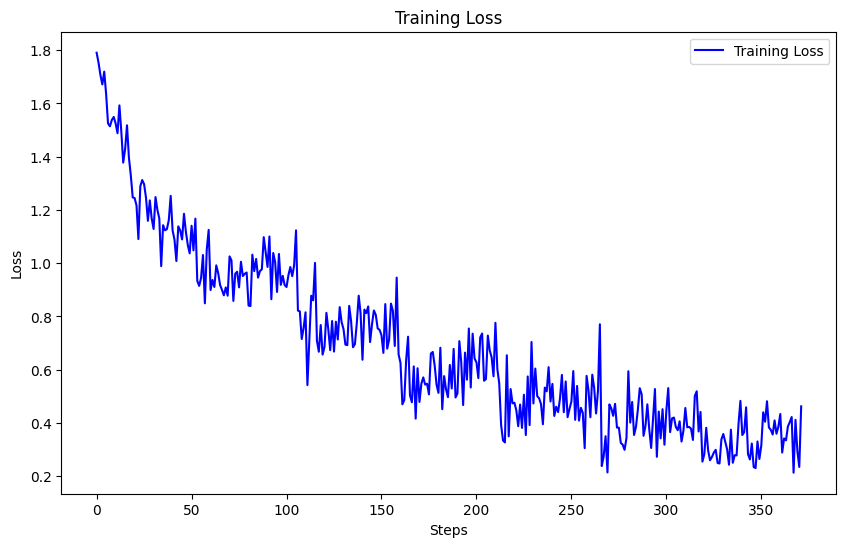

In [ ]:
# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
# plt.plot(eval_loss, label='Validation Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

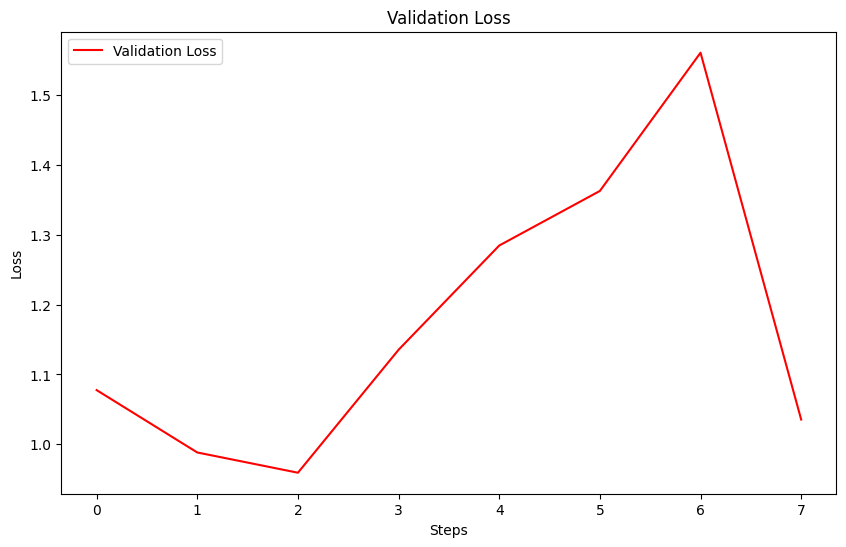

In [ ]:
# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(eval_loss, label='Validation Loss', color='red')
plt.title('Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Step 1: Make predictions on the test set
predictions, labels, _ = trainer.predict(val_dataset)

# Step 2: Convert logits to predicted labels (using argmax to get the highest probability class)
predicted_labels = np.argmax(predictions, axis=1)

# Step 3: Calculate evaluation metrics
accuracy = accuracy_score(labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_labels, average='weighted', zero_division=0)

# Step 4: Print results
print(f"Accuracy on valset: {accuracy:.4f}")
print(f"Precision on valset: {precision:.4f}")
print(f"Recall on valset: {recall:.4f}")
print(f"F1 Score on valset: {f1:.4f}")

Accuracy on valset: 0.6846
Precision on valset: 0.6683
Recall on valset: 0.6846
F1 Score on valset: 0.6655


In [ ]:
# Step 1: Make predictions on the test set
predictions, labels, _ = trainer.predict(test_dataset)

# Step 2: Convert logits to predicted labels (using argmax to get the highest probability class)
predicted_labels = np.argmax(predictions, axis=1)

# Step 3: Calculate evaluation metrics
accuracy = accuracy_score(labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_labels, average='weighted', zero_division=0)

# Step 4: Print results
print(f"Accuracy on testset: {accuracy:.4f}")
print(f"Precision on testset: {precision:.4f}")
print(f"Recall on testset: {recall:.4f}")
print(f"F1 Score on testset: {f1:.4f}")

Accuracy on testset: 0.6416
Precision on testset: 0.6548
Recall on testset: 0.6416
F1 Score on testset: 0.6160


In [ ]:
print(f"Classification Report: {classification_report(labels, predicted_labels)}")

Classification Report:               precision    recall  f1-score   support

           0       0.48      0.40      0.43        75
           1       0.73      0.08      0.15        95
           2       0.61      0.48      0.53       138
           3       0.81      0.69      0.75       226
           4       0.62      0.85      0.71       407
           5       0.60      0.62      0.61       122

    accuracy                           0.64      1063
   macro avg       0.64      0.52      0.53      1063
weighted avg       0.65      0.64      0.62      1063



In [ ]:
model.save_pretrained("./phobert_model")
tokenizer.save_pretrained("./phobert_model")

('./phobert_model/tokenizer_config.json',
 './phobert_model/special_tokens_map.json',
 './phobert_model/vocab.txt',
 './phobert_model/bpe.codes',
 './phobert_model/added_tokens.json')

## VisoBERT

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("uitnlp/visobert")

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/471k [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=258)

# Apply the tokenizer to all splits
train_dataset = train_data.map(tokenize_function, batched=True)
val_dataset = val_data.map(tokenize_function, batched=True)
test_dataset = test_data.map(tokenize_function, batched=True)

Map:   0%|          | 0/8498 [00:00<?, ? examples/s]

Map:   0%|          | 0/1062 [00:00<?, ? examples/s]

Map:   0%|          | 0/1063 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("uitnlp/visobert", num_labels=6)

pytorch_model.bin:   0%|          | 0.00/390M [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,                # Bạn có thể thử 10 epoch
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir='./logs',
    logging_steps=10,
    weight_decay=0.01,
    warmup_steps=500,
    max_grad_norm=1.0,
    # Giới hạn sớm khi không cải thiện
    eval_steps=500,
    save_total_limit=2,
)

early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=4)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]  # Thêm callback early stopping
)

In [ ]:
# Start training
trainer.train()

A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.071600,1.089577,0.594162,0.609249,0.594162,0.575620
2,1.051200,0.985341,0.657250,0.642000,0.657250,0.642378
3,0.791500,1.131866,0.645009,0.642079,0.645009,0.633072
4,0.475000,1.301319,0.603578,0.607344,0.603578,0.603020
5,0.283300,1.601976,0.620527,0.626353,0.620527,0.620254
6,0.404800,1.782287,0.601695,0.618146,0.601695,0.605993


model.safetensors:   0%|          | 0.00/390M [00:00<?, ?B/s]

TrainOutput(global_step=3192, training_loss=0.6316555223677466, metrics={'train_runtime': 1662.2138, 'train_samples_per_second': 102.249, 'train_steps_per_second': 6.401, 'total_flos': 6760400354485344.0, 'train_loss': 0.6316555223677466, 'epoch': 6.0})

In [ ]:
results = trainer.evaluate(test_dataset)
print(f"Evaluation Results: {results}")

Evaluation Results: {'eval_loss': 1.087052583694458, 'eval_accuracy': 0.6190028222013171, 'eval_precision': 0.6072687852982255, 'eval_recall': 0.6190028222013171, 'eval_f1': 0.605590055724793, 'eval_runtime': 9.4245, 'eval_samples_per_second': 112.792, 'eval_steps_per_second': 3.608, 'epoch': 6.0}


In [ ]:
history = trainer.state.log_history
train_loss = [entry['loss'] for entry in history if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in history if 'eval_loss' in entry]

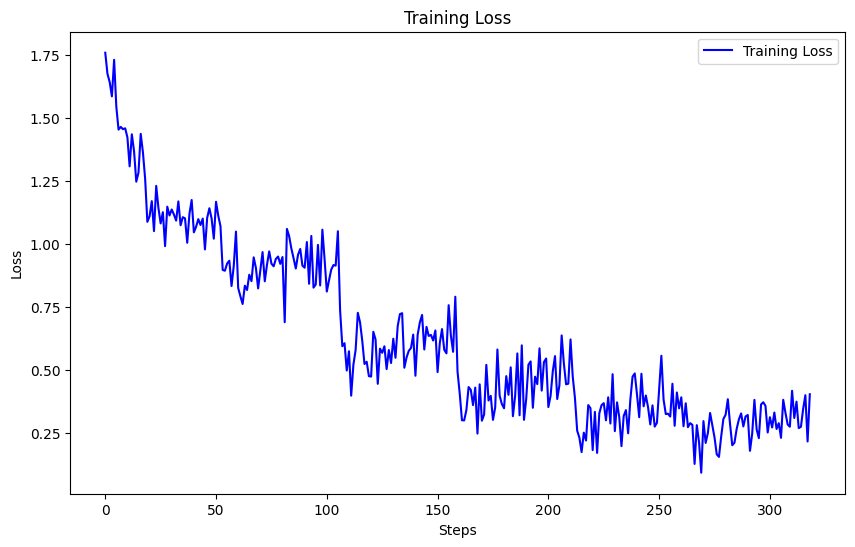

In [ ]:
# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
# plt.plot(eval_loss, label='Validation Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

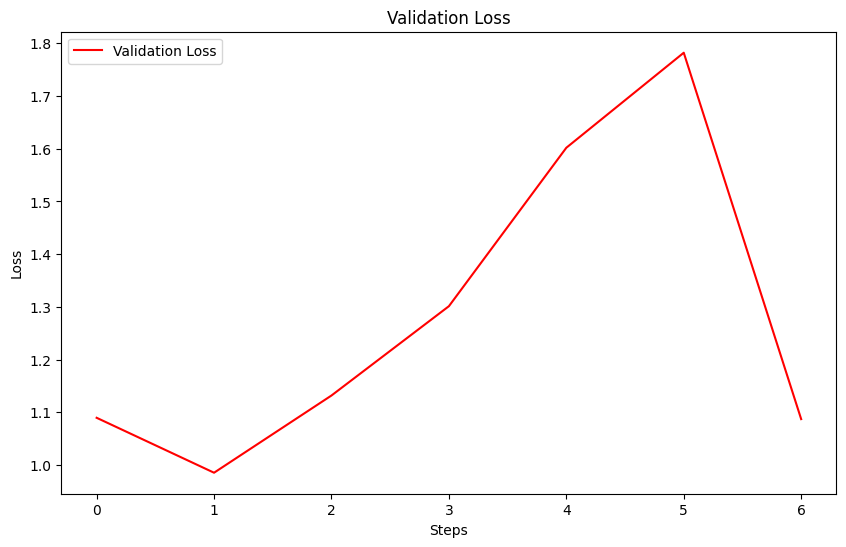

In [ ]:
# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(eval_loss, label='Validation Loss', color='red')
plt.title('Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Step 1: Make predictions on the test set
predictions, labels, _ = trainer.predict(val_dataset)

# Step 2: Convert logits to predicted labels (using argmax to get the highest probability class)
predicted_labels = np.argmax(predictions, axis=1)

# Step 3: Calculate evaluation metrics
accuracy = accuracy_score(labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_labels, average='weighted', zero_division=0)

# Step 4: Print results
print(f"Accuracy on valset: {accuracy:.4f}")
print(f"Precision on valset: {precision:.4f}")
print(f"Recall on valset: {recall:.4f}")
print(f"F1 Score on valset: {f1:.4f}")

Accuracy on valset: 0.6573
Precision on valset: 0.6420
Recall on valset: 0.6573
F1 Score on valset: 0.6424


In [ ]:
# Step 1: Make predictions on the test set
predictions, labels, _ = trainer.predict(test_dataset)

# Step 2: Convert logits to predicted labels (using argmax to get the highest probability class)
predicted_labels = np.argmax(predictions, axis=1)

# Step 3: Calculate evaluation metrics
accuracy = accuracy_score(labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_labels, average='weighted', zero_division=0)

# Step 4: Print results
print(f"Accuracy on testset: {accuracy:.4f}")
print(f"Precision on testset: {precision:.4f}")
print(f"Recall on testset: {recall:.4f}")
print(f"F1 Score on testset: {f1:.4f}")

Accuracy on testset: 0.6190
Precision on testset: 0.6073
Recall on testset: 0.6190
F1 Score on testset: 0.6056


In [ ]:
print(f"Classification Report: {classification_report(labels, predicted_labels)}")

Classification Report:               precision    recall  f1-score   support

           0       0.49      0.40      0.44        75
           1       0.47      0.24      0.32        95
           2       0.53      0.49      0.51       138
           3       0.63      0.75      0.68       226
           4       0.67      0.76      0.71       407
           5       0.63      0.47      0.54       122

    accuracy                           0.62      1063
   macro avg       0.57      0.52      0.53      1063
weighted avg       0.61      0.62      0.61      1063



In [ ]:
model.save_pretrained("./visobert_model")
tokenizer.save_pretrained("./visobert_model")

('./visobert_model/tokenizer_config.json',
 './visobert_model/special_tokens_map.json',
 './visobert_model/sentencepiece.bpe.model',
 './visobert_model/added_tokens.json',
 './visobert_model/tokenizer.json')

## XLM Roberta

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=258)

# Apply the tokenizer to all splits
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/8498 [00:00<?, ? examples/s]

Map:   0%|          | 0/1062 [00:00<?, ? examples/s]

Map:   0%|          | 0/1063 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=6)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,                # Bạn có thể thử 10 epoch
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir='./logs',
    logging_steps=10,
    weight_decay=0.01,
    warmup_steps=500,
    max_grad_norm=1.0,
    # Giới hạn sớm khi không cải thiện
    eval_steps=500,
    save_total_limit=2,
)

early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=4)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]  # Thêm callback early stopping
)

In [ ]:
# Start training
trainer.train()

A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.305600,1.254966,0.546139,0.435219,0.546139,0.463153
2,1.312600,1.121766,0.605461,0.568220,0.605461,0.583530
3,1.281200,1.133919,0.604520,0.606947,0.604520,0.555955
4,1.019300,1.017042,0.641243,0.628795,0.641243,0.622161
5,0.798900,1.068603,0.629944,0.615462,0.629944,0.614263
6,0.812000,1.067783,0.612994,0.619574,0.612994,0.612690
7,0.741600,1.237471,0.599812,0.617823,0.599812,0.602037
8,0.597400,1.306783,0.606403,0.597444,0.606403,0.600881


TrainOutput(global_step=4256, training_loss=0.9868112008150359, metrics={'train_runtime': 3155.2971, 'train_samples_per_second': 53.865, 'train_steps_per_second': 3.372, 'total_flos': 9013867139313792.0, 'train_loss': 0.9868112008150359, 'epoch': 8.0})

In [ ]:
results = trainer.evaluate(test_dataset)
print(f"Evaluation Results: {results}")

Evaluation Results: {'eval_loss': 1.0819770097732544, 'eval_accuracy': 0.6077140169332079, 'eval_precision': 0.5924961421785591, 'eval_recall': 0.6077140169332079, 'eval_f1': 0.5800164702120827, 'eval_runtime': 11.4884, 'eval_samples_per_second': 92.528, 'eval_steps_per_second': 2.959, 'epoch': 8.0}


In [ ]:
history = trainer.state.log_history
train_loss = [entry['loss'] for entry in history if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in history if 'eval_loss' in entry]

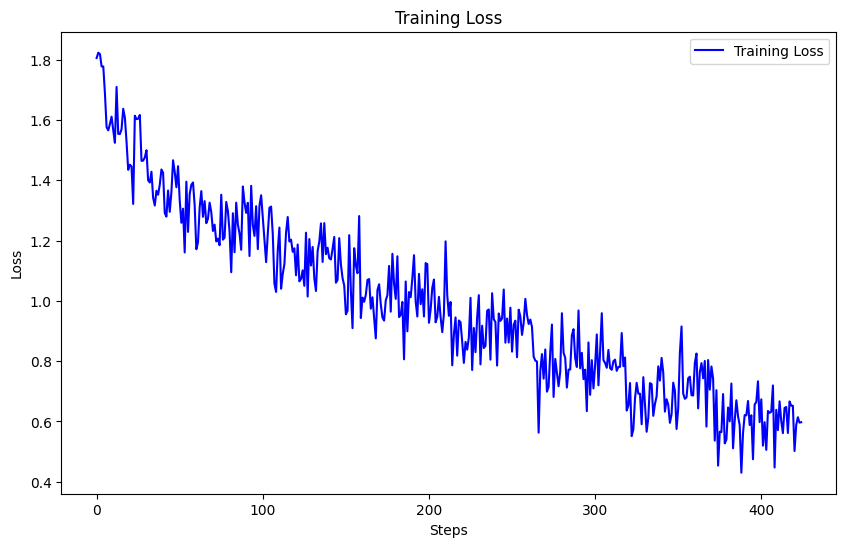

In [ ]:
# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
# plt.plot(eval_loss, label='Validation Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

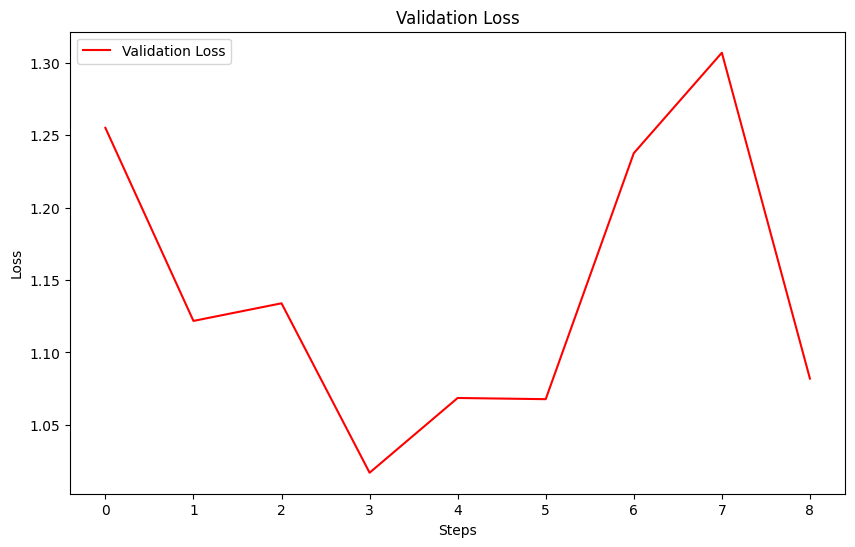

In [ ]:
# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(eval_loss, label='Validation Loss', color='red')
plt.title('Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Step 1: Make predictions on the test set
predictions, labels, _ = trainer.predict(val_dataset)

# Step 2: Convert logits to predicted labels (using argmax to get the highest probability class)
predicted_labels = np.argmax(predictions, axis=1)

# Step 3: Calculate evaluation metrics
accuracy = accuracy_score(labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_labels, average='weighted', zero_division=0)

# Step 4: Print results
print(f"Accuracy on valset: {accuracy:.4f}")
print(f"Precision on valset: {precision:.4f}")
print(f"Recall on valset: {recall:.4f}")
print(f"F1 Score on valset: {f1:.4f}")


Accuracy on valset: 0.6412
Precision on valset: 0.6288
Recall on valset: 0.6412
F1 Score on valset: 0.6222


In [ ]:
# Step 1: Make predictions on the test set
predictions, labels, _ = trainer.predict(test_dataset)

# Step 2: Convert logits to predicted labels (using argmax to get the highest probability class)
predicted_labels = np.argmax(predictions, axis=1)

# Step 3: Calculate evaluation metrics
accuracy = accuracy_score(labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_labels, average='weighted', zero_division=0)

# Step 4: Print results
print(f"Accuracy on testset: {accuracy:.4f}")
print(f"Precision on testset: {precision:.4f}")
print(f"Recall on testset: {recall:.4f}")
print(f"F1 Score on testset: {f1:.4f}")

Accuracy on testset: 0.6077
Precision on testset: 0.5925
Recall on testset: 0.6077
F1 Score on testset: 0.5800


In [ ]:
print(f"Classification Report: {classification_report(labels, predicted_labels)}")

Classification Report:               precision    recall  f1-score   support

           0       0.42      0.29      0.35        75
           1       0.40      0.04      0.08        95
           2       0.55      0.50      0.52       138
           3       0.74      0.64      0.69       226
           4       0.63      0.80      0.70       407
           5       0.50      0.66      0.57       122

    accuracy                           0.61      1063
   macro avg       0.54      0.49      0.48      1063
weighted avg       0.59      0.61      0.58      1063



In [ ]:
model.save_pretrained("./xlm_roberta_model")
tokenizer.save_pretrained("./xlm_roberta_model")

('./xlm_roberta_model/tokenizer_config.json',
 './xlm_roberta_model/special_tokens_map.json',
 './xlm_roberta_model/sentencepiece.bpe.model',
 './xlm_roberta_model/added_tokens.json',
 './xlm_roberta_model/tokenizer.json')

## mBERT

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=258)

# Apply the tokenizer to all splits
train_dataset = train_data.map(tokenize_function, batched=True)
val_dataset = val_data.map(tokenize_function, batched=True)
test_dataset = test_data.map(tokenize_function, batched=True)

Map:   0%|          | 0/8498 [00:00<?, ? examples/s]

Map:   0%|          | 0/1062 [00:00<?, ? examples/s]

Map:   0%|          | 0/1063 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=6)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,                # Bạn có thể thử 10 epoch
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir='./logs',
    logging_steps=10,
    weight_decay=0.01,
    warmup_steps=500,
    max_grad_norm=1.0,
    # Giới hạn sớm khi không cải thiện
    eval_steps=500,
    save_total_limit=2,
)

early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=4)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]  # Thêm callback early stopping
)

In [ ]:
trainer.train()

A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.266300,1.153145,0.572505,0.508437,0.572505,0.509264
2,1.153600,1.067974,0.612994,0.588344,0.612994,0.585401
3,1.045400,1.052449,0.621469,0.604072,0.621469,0.595903
4,0.770400,1.118036,0.636535,0.626435,0.636535,0.628745
5,0.673100,1.245174,0.611111,0.614228,0.611111,0.609350
6,0.619400,1.292109,0.629944,0.628243,0.629944,0.624124
7,0.537400,1.434342,0.597928,0.640439,0.597928,0.611703


TrainOutput(global_step=3724, training_loss=0.8173609542091218, metrics={'train_runtime': 2308.0807, 'train_samples_per_second': 73.637, 'train_steps_per_second': 4.61, 'total_flos': 7887133746899568.0, 'train_loss': 0.8173609542091218, 'epoch': 7.0})

In [ ]:
results = trainer.evaluate(test_dataset)
print(f"Evaluation Results: {results}")

Evaluation Results: {'eval_loss': 1.1080784797668457, 'eval_accuracy': 0.6105362182502352, 'eval_precision': 0.609248076944567, 'eval_recall': 0.6105362182502352, 'eval_f1': 0.5811697516920152, 'eval_runtime': 11.0431, 'eval_samples_per_second': 96.259, 'eval_steps_per_second': 3.079, 'epoch': 7.0}


In [ ]:
history = trainer.state.log_history
train_loss = [entry['loss'] for entry in history if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in history if 'eval_loss' in entry]

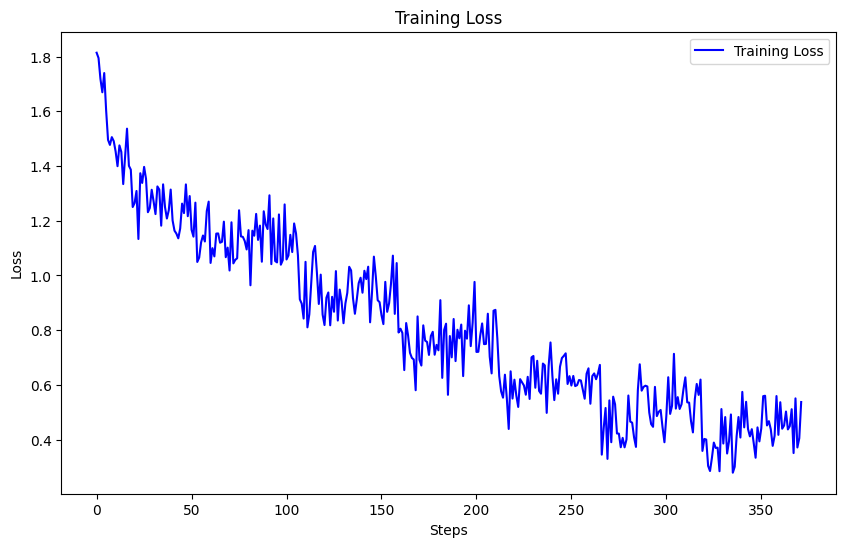

In [ ]:
# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
# plt.plot(eval_loss, label='Validation Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

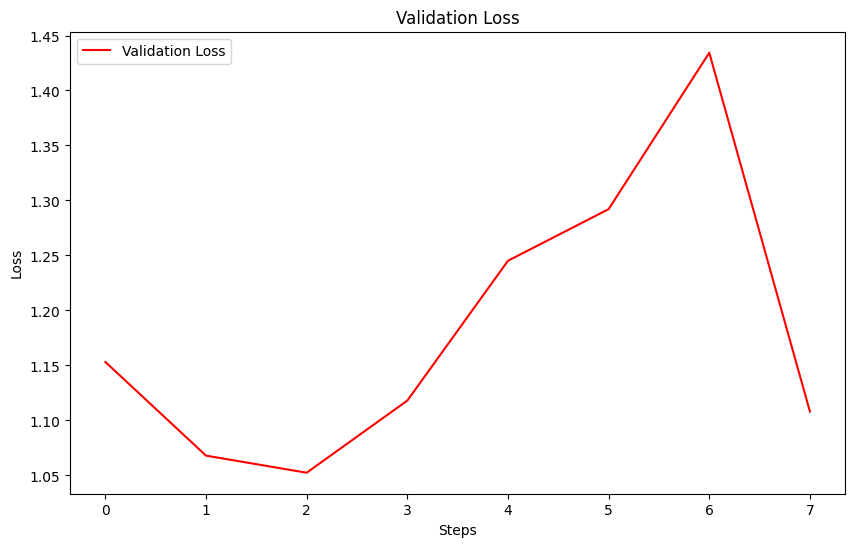

In [ ]:
# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(eval_loss, label='Validation Loss', color='red')
plt.title('Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Step 1: Make predictions on the test set
predictions, labels, _ = trainer.predict(val_dataset)

# Step 2: Convert logits to predicted labels (using argmax to get the highest probability class)
predicted_labels = np.argmax(predictions, axis=1)

# Step 3: Calculate evaluation metrics
accuracy = accuracy_score(labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_labels, average='weighted', zero_division=0)

# Step 4: Print results
print(f"Accuracy on valset: {accuracy:.4f}")
print(f"Precision on valset: {precision:.4f}")
print(f"Recall on valset: {recall:.4f}")
print(f"F1 Score on valset: {f1:.4f}")

Accuracy on valset: 0.6215
Precision on valset: 0.6041
Recall on valset: 0.6215
F1 Score on valset: 0.5959


In [ ]:
# Step 1: Make predictions on the test set
predictions, labels, _ = trainer.predict(test_dataset)

# Step 2: Convert logits to predicted labels (using argmax to get the highest probability class)
predicted_labels = np.argmax(predictions, axis=1)

# Step 3: Calculate evaluation metrics
accuracy = accuracy_score(labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_labels, average='weighted', zero_division=0)

# Step 4: Print results
print(f"Accuracy on testset: {accuracy:.4f}")
print(f"Precision on testset: {precision:.4f}")
print(f"Recall on testset: {recall:.4f}")
print(f"F1 Score on testset: {f1:.4f}")

Accuracy on testset: 0.6105
Precision on testset: 0.6092
Recall on testset: 0.6105
F1 Score on testset: 0.5812


In [ ]:
print(f"Classification Report: {classification_report(labels, predicted_labels)}")

Classification Report:               precision    recall  f1-score   support

           0       0.53      0.35      0.42        75
           1       0.40      0.06      0.11        95
           2       0.55      0.48      0.51       138
           3       0.86      0.62      0.72       226
           4       0.59      0.88      0.71       407
           5       0.50      0.43      0.46       122

    accuracy                           0.61      1063
   macro avg       0.57      0.47      0.49      1063
weighted avg       0.61      0.61      0.58      1063



In [ ]:
model.save_pretrained("./mbert_model")
tokenizer.save_pretrained("./mbert_model")

('./mbert_model/tokenizer_config.json',
 './mbert_model/special_tokens_map.json',
 './mbert_model/vocab.txt',
 './mbert_model/added_tokens.json',
 './mbert_model/tokenizer.json')